In [37]:
import tensorflow as tf
import os

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
folder_path =  '/content/drive/MyDrive/chest_xray'

In [39]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [40]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(folder_path)

There are 3 directories and 0 images in '/content/drive/MyDrive/chest_xray'.
There are 2 directories and 0 images in '/content/drive/MyDrive/chest_xray/test'.
There are 0 directories and 234 images in '/content/drive/MyDrive/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'.
There are 2 directories and 0 images in '/content/drive/MyDrive/chest_xray/val'.
There are 0 directories and 8 images in '/content/drive/MyDrive/chest_xray/val/NORMAL'.
There are 0 directories and 8 images in '/content/drive/MyDrive/chest_xray/val/PNEUMONIA'.
There are 2 directories and 0 images in '/content/drive/MyDrive/chest_xray/train'.
There are 0 directories and 1341 images in '/content/drive/MyDrive/chest_xray/train/NORMAL'.
There are 0 directories and 3649 images in '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'.


In [41]:
train_folder = folder_path + "/train"

In [42]:
val_folder = folder_path + "/val"
test_folder = folder_path + "/test"

In [43]:
class_names = sorted(os.listdir(train_folder))
print(class_names)

['NORMAL', 'PNEUMONIA']


In [44]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)

    random_images = random.sample(os.listdir(target_folder), 9)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        img_path = os.path.join(target_folder, random_images[i])
        img = mpimg.imread(img_path)
        ax.imshow(img, aspect= "auto")
        ax.axis("off")

    plt.suptitle(target_class, fontsize=16)
    plt.tight_layout()
    plt.show()

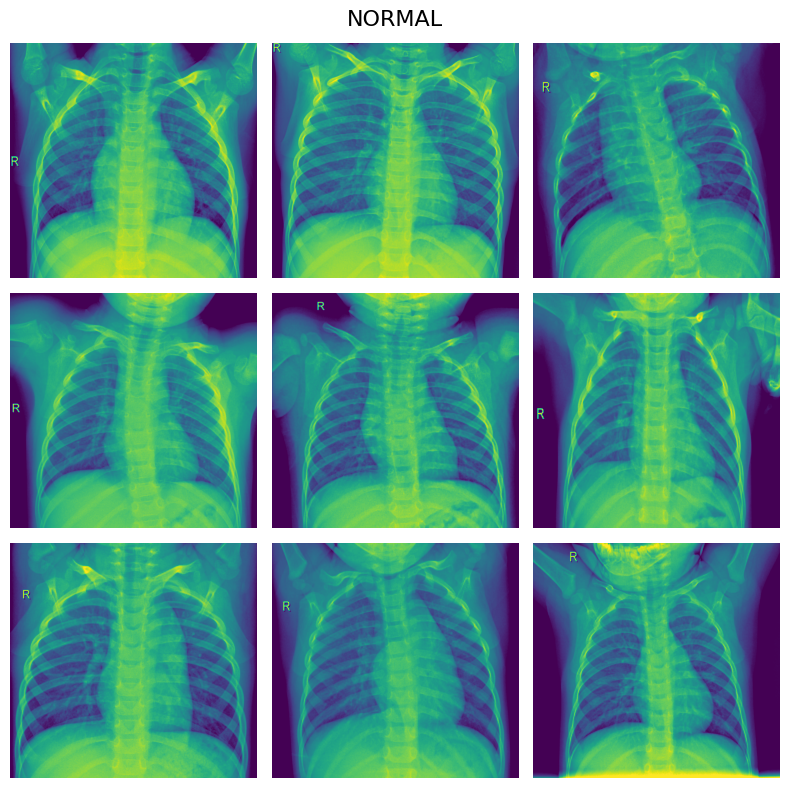

In [45]:
view_random_images(train_folder, "NORMAL")


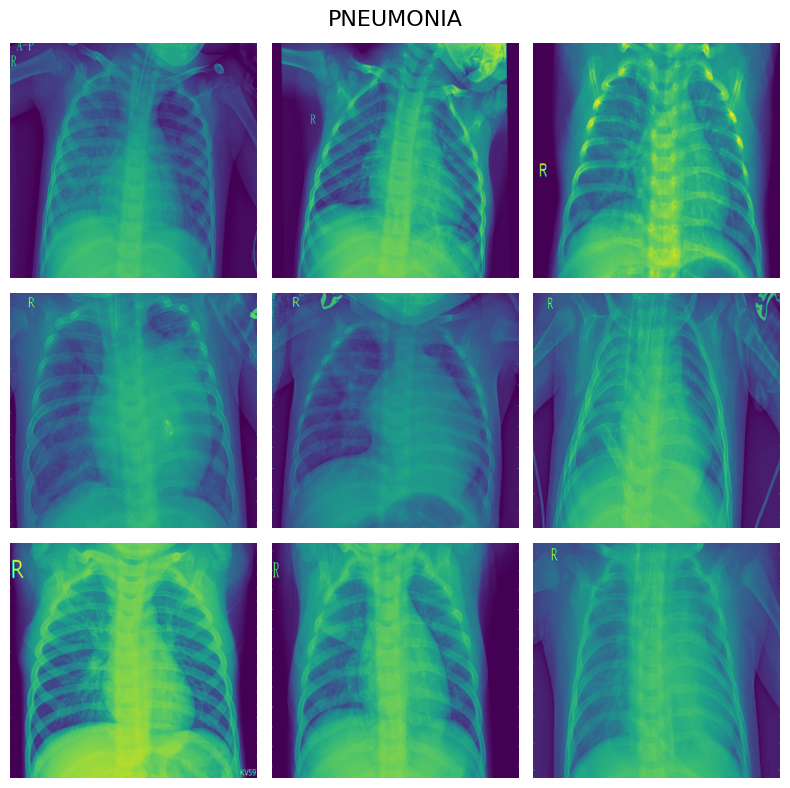

In [46]:
view_random_images(train_folder, "PNEUMONIA")


In [47]:
def create_barplot(target_dir):
    class_counts = []
    class_names = []

    # Iterate over subdirectories
    for root, dirs, files in os.walk(target_dir):
        if len(files) > 0:
            class_counts.append(len(files))
            class_names.append(os.path.basename(root))



    # Plot the bar graph
    plt.bar(class_names, class_counts)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Counts")
    plt.xticks(rotation=90)
    for i, count in enumerate(class_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

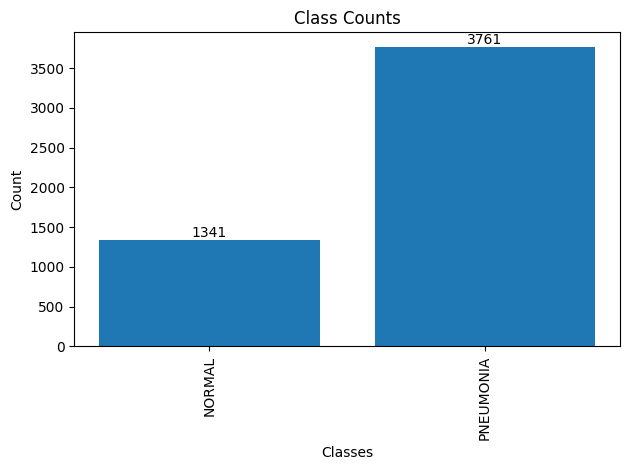

In [48]:
create_barplot(train_folder)


In [233]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):


  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

##Modeling

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [50]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True)

Val_data_gen = ImageDataGenerator(rescale=1/255.)


test_data_gen = ImageDataGenerator(rescale=1/255.)

In [262]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_folder,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   color_mode="grayscale",
                                                                   shuffle=True)

val_data = Val_data_gen.flow_from_directory(val_folder,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             color_mode="grayscale",
                                             class_mode='binary')

test_data = test_data_gen.flow_from_directory(test_folder,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             color_mode="grayscale",
                                             class_mode='binary',
                                             shuffle = False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [52]:
images, labels = train_data_augmented.next()
len(images)

32

In [70]:
checkpoint_path1 = "model_checkpoints/cp1.ckpt" # saving weights requires ".ckpt" extension
checkpoint_path2 = "model_checkpoints/cp2.ckpt" # saving weights requires ".ckpt" extension
checkpoint_path3 = "model_checkpoints/cp3.ckpt" # saving weights requires ".ckpt" extension
checkpoint_path4 = "model_checkpoints/cp4.ckpt" # saving weights requires ".ckpt" extension

model_checkpoint1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path1,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)
model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)
model_checkpoint3 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path3,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)
model_checkpoint4 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path4,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)

In [71]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

In [72]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1
)

In [73]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [274]:
import numpy as np

# Initialize an empty list to store the class labels
y_labels1 = []

# Get the total number of steps in the test data generator
num_steps = len(test_data)

# Iterate over the test data generator for the specified number of steps
for _ in range(num_steps):
    # Get a batch of data
    _, labels = next(test_data)

    # Convert the labels to a list
    labels_list = labels.tolist()

    # Extend the y_labels list with the labels
    y_labels1.extend(labels_list)

# Print the first 10 class labels
print(y_labels1[:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [270]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 1)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_augmented, # changed to augmented training data
                        epochs=12,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[model_checkpoint1,early_stopping, reduce_lr_callback])


Epoch 1/12
163/163 [==============================] - 76s 455ms/step - loss: 0.5127 - accuracy: 0.7600 - val_loss: 0.8018 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 74s 455ms/step - loss: 0.3538 - accuracy: 0.8382 - val_loss: 0.6968 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 74s 455ms/step - loss: 0.3402 - accuracy: 0.8462 - val_loss: 0.5635 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 75s 460ms/step - loss: 0.2982 - accuracy: 0.8645 - val_loss: 0.7090 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - 74s 455ms/step - loss: 0.2915 - accuracy: 0.8715 - val_loss: 0.6738 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/12
163/163 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.8781
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
163/163 [============================

In [75]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      100       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 10)      

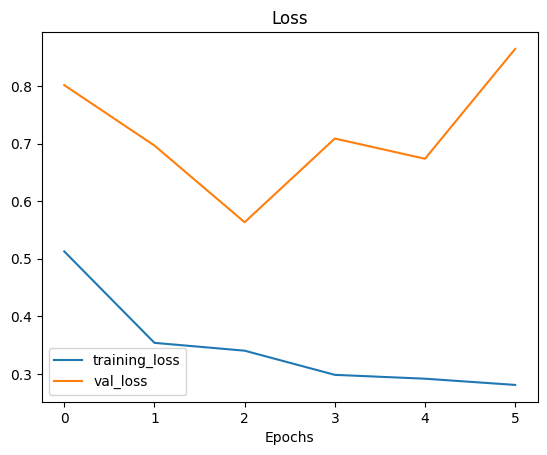

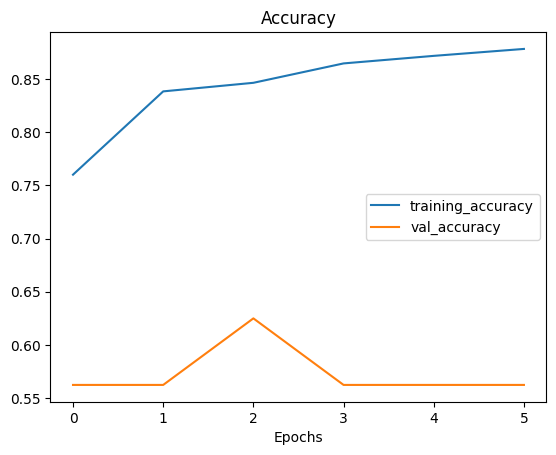

In [277]:
plot_loss_curves(history_1)

In [271]:
preds_1=model_1.predict(test_data, verbose=1)
threshold = 0.5
predicted_labels_1 = (preds_1 >= threshold).astype(int)


20/20 [==============================] - 6s 254ms/step


In [275]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels1, predicted_labels_1)
accuracy


0.7163461538461539

Confusion Matrix:
[[ 61 173]
 [  4 386]]


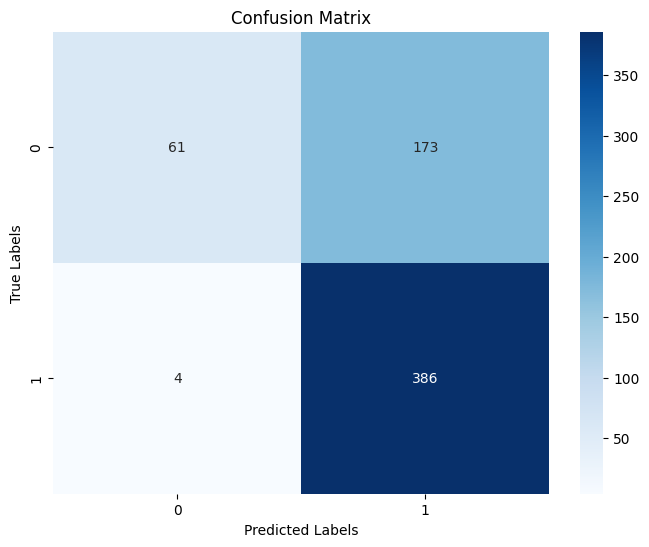

In [276]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_labels1, predicted_labels_1)
print("Confusion Matrix:")
print(cm)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [278]:
from sklearn.metrics import classification_report
report = classification_report(y_labels1, predicted_labels_1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.26      0.41       234
         1.0       0.69      0.99      0.81       390

    accuracy                           0.72       624
   macro avg       0.81      0.63      0.61       624
weighted avg       0.78      0.72      0.66       624



In [280]:
# Print the classification report

model1results = calculate_results(y_labels1, predicted_labels_1)
model1results

{'accuracy': 71.63461538461539,
 'precision': 0.7834973166368514,
 'recall': 0.7163461538461539,
 'f1': 0.6614399596829614}

In [77]:
model_2 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 1)),
  BatchNormalization(),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(64, 3, activation='relu'),
  Dropout(0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=2),
  Conv2D(128, 3, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2),
  Conv2D(256, 3, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2),
  Flatten(),
  Dense(units = 128 , activation = 'relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')

])

In [78]:
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [232]:

# Fit the model
history_2 = model_2.fit(train_data_augmented, # changed to augmented training data
                        epochs=12,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks= [model_checkpoint2, early_stopping, reduce_lr_callback])

Epoch 1/12
160/160 [==============================] - 73s 454ms/step - loss: 0.1523 - accuracy: 0.9379 - val_loss: 2.9961 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/12
160/160 [==============================] - 73s 455ms/step - loss: 0.1420 - accuracy: 0.9475 - val_loss: 4.4531 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 3/12
160/160 [==============================] - 74s 461ms/step - loss: 0.1389 - accuracy: 0.9488 - val_loss: 1.7324 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/12
160/160 [==============================] - 73s 457ms/step - loss: 0.1295 - accuracy: 0.9485 - val_loss: 4.8125 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/12
160/160 [==============================] - 73s 458ms/step - loss: 0.1284 - accuracy: 0.9516 - val_loss: 1.0352 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 6/12
160/160 [==============================] - 74s 460ms/step - loss: 0.1307 - accuracy: 0.9553 - val_loss: 0.7480 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 7/12
160/160 [========

In [80]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 64)    

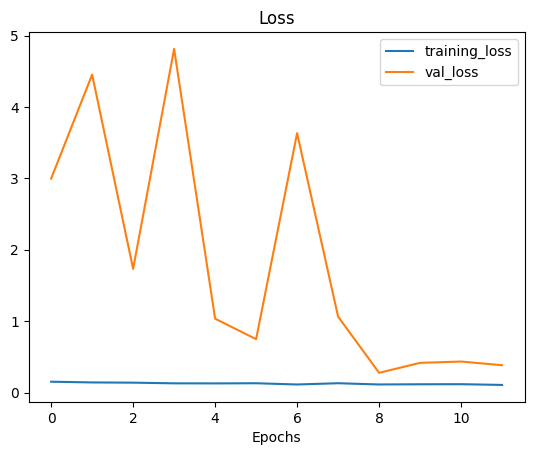

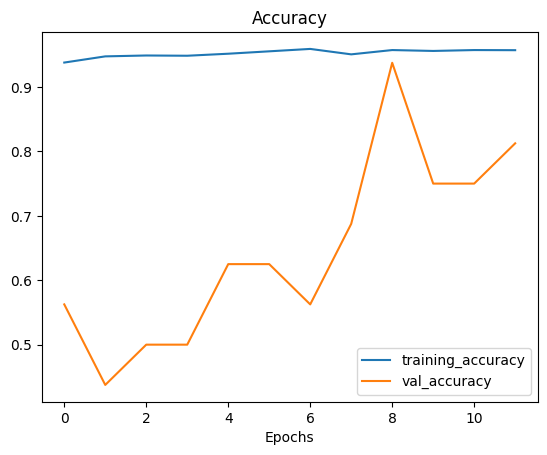

In [234]:
plot_loss_curves(history_2)

In [282]:
preds_2=model_2.predict(test_data, verbose=1)
threshold = 0.5
predicted_labels_2= (preds_2 >= threshold).astype(int)


20/20 [==============================] - 6s 255ms/step


In [283]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels1, predicted_labels_2)
accuracy


0.8782051282051282

In [284]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_labels1, predicted_labels_2)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[203  31]
 [ 45 345]]


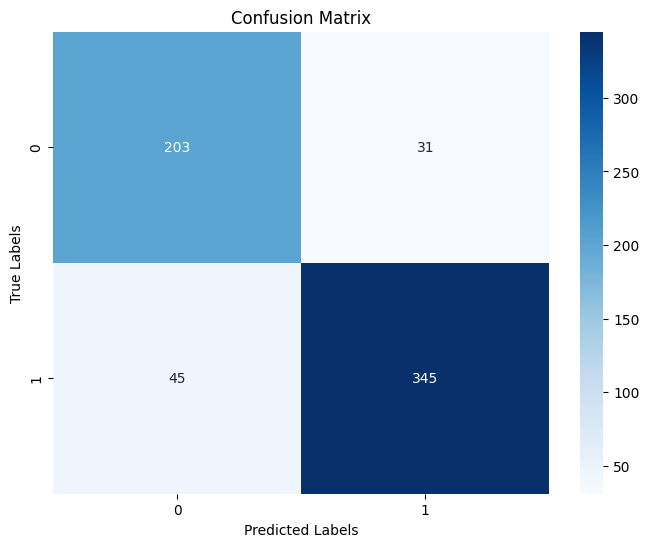

In [285]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [286]:
from sklearn.metrics import classification_report
report = classification_report(y_labels1, predicted_labels_2)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       234
         1.0       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624



In [287]:
model2_results = calculate_results(y_labels1, predicted_labels_2)
model2_results

{'accuracy': 87.82051282051282,
 'precision': 0.8804263898421414,
 'recall': 0.8782051282051282,
 'f1': 0.8788609254303762}

##TransferLearning

In [114]:
IMAGE_SHAPE=(224,224)

In [115]:
efficient_net ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [124]:
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,),
                                             dtype = tf.float32)

    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

In [125]:
eff_model = create_model(efficient_net)

# Compile
eff_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [131]:
images, _= train_data_augmented.next()

In [133]:
images[0].shape

(224, 224, 1)

In [166]:
def preprocess_input(image, label):
    rgb_image = tf.image.grayscale_to_rgb(image)
    return rgb_image, label

train_datagen_augmented_rgb = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True,
                                             preprocessing_function=preprocess_input)

Val_data_gen_rgb = ImageDataGenerator(rescale=1/255., preprocessing_function=preprocess_input)


test_data_gen_rgb = ImageDataGenerator(rescale=1/255.,preprocessing_function=preprocess_input)



train_data_augmented_rgb = train_datagen_augmented.flow_from_directory(train_folder,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

val_data_rgb= Val_data_gen.flow_from_directory(val_folder,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

test_data_rgb = test_data_gen.flow_from_directory(test_folder,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary',
                                             shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [136]:

efficientnet_history = eff_model.fit(train_data_augmented_rgb,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_augmented_rgb),
                                  validation_data=val_data_rgb,
                                  validation_steps=len(val_data_rgb),
                                  callbacks= [model_checkpoint3, early_stopping, reduce_lr_callback])


Epoch 1/10
163/163 [==============================] - 183s 1s/step - loss: 0.2934 - accuracy: 0.8725 - val_loss: 0.3835 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 112s 688ms/step - loss: 0.1977 - accuracy: 0.9260 - val_loss: 0.3489 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 112s 688ms/step - loss: 0.1708 - accuracy: 0.9377 - val_loss: 0.4155 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 112s 688ms/step - loss: 0.1517 - accuracy: 0.9465 - val_loss: 0.3074 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 112s 688ms/step - loss: 0.1447 - accuracy: 0.9490 - val_loss: 0.2712 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 112s 687ms/step - loss: 0.1336 - accuracy: 0.9528 - val_loss: 0.2773 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/10
163/163 [=============================

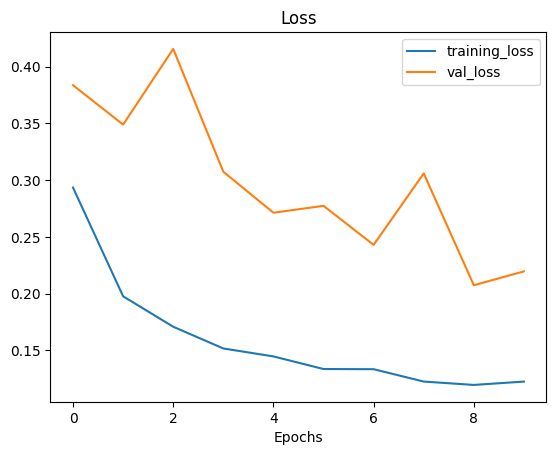

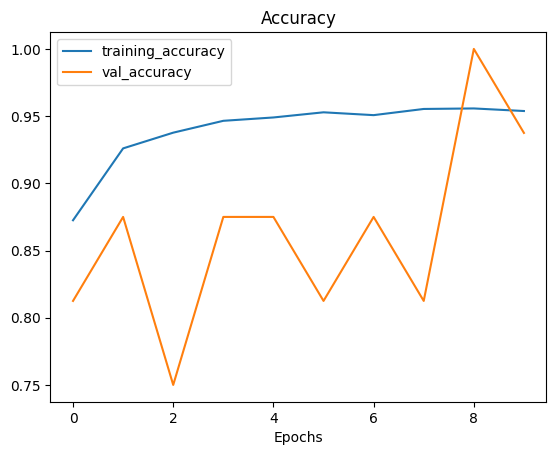

In [137]:
plot_loss_curves(efficientnet_history)


In [138]:
eff_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 1,281
Non-trainable params: 5,919,312
_________________________________________________________________


##Predictions

In [167]:
preds=eff_model.predict(test_data_rgb, verbose=1)

20/20 [==============================] - 6s 294ms/step


In [168]:
preds.max()

1.0

In [169]:
threshold = 0.5
predicted_labels = (preds >= threshold).astype(int)


In [175]:
# Count the occurrences of each label
label_counts = np.bincount(predicted_labels.flatten())

# Get the count of labels corresponding to 0 and 1
count_0 = label_counts[0]
count_1 = label_counts[1]

# Print the counts
print("Count of labels 0:", count_0)
print("Count of labels 1:", count_1)

Count of labels 0: 197
Count of labels 1: 427


In [176]:
import numpy as np

# Initialize an empty list to store the class labels
y_labels = []

# Get the total number of steps in the test data generator
num_steps = len(test_data_rgb)

# Iterate over the test data generator for the specified number of steps
for _ in range(num_steps):
    # Get a batch of data
    _, labels = next(test_data_rgb)

    # Convert the labels to a list
    labels_list = labels.tolist()

    # Extend the y_labels list with the labels
    y_labels.extend(labels_list)

# Print the first 10 class labels
print(y_labels[:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [177]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, predicted_labels)
accuracy

0.905448717948718

Confusion Matrix:
[[186  48]
 [ 11 379]]


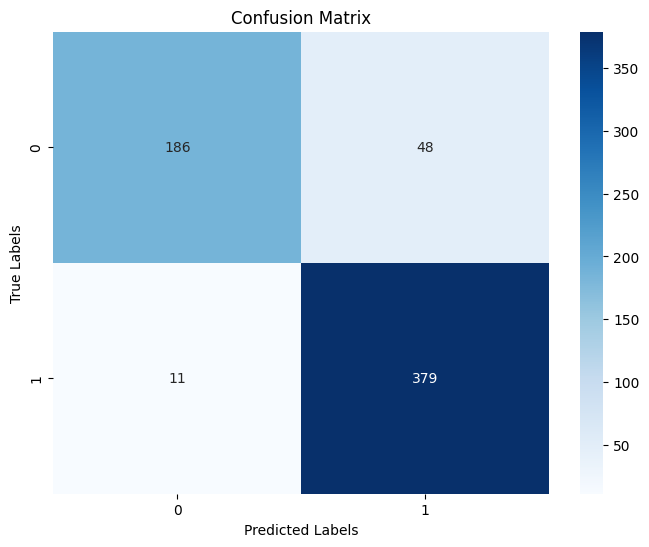

In [180]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [181]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86       234
         1.0       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



In [185]:
efficientnet_results = calculate_results(y_labels, predicted_labels)
efficientnet_results

{'accuracy': 90.5448717948718,
 'precision': 0.9088033024643659,
 'recall': 0.905448717948718,
 'f1': 0.9035312543485731}

In [186]:

def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 26ms/step
1


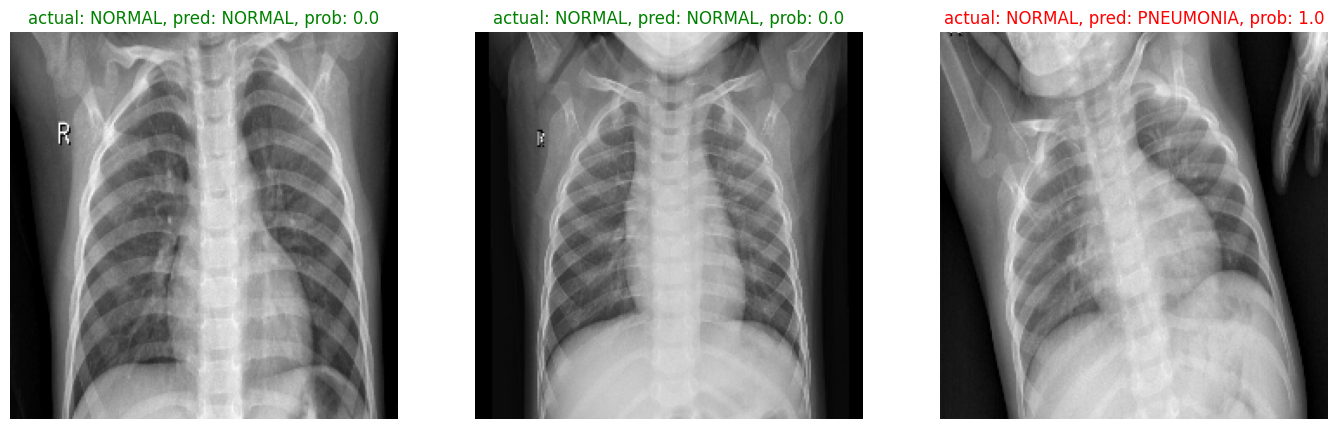

In [225]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  class_folder = os.path.join(test_folder, class_name)
  filenames = os.listdir(class_folder)
  filename = random.choice(filenames)
  filepath = os.path.join(class_folder, filename)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_rgb = tf.image.grayscale_to_rgb(img)
  pred_prob = eff_model.predict(tf.expand_dims(img_rgb, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  threshold = 0.5
  predicted_value = np.squeeze((pred_prob >= threshold).astype(int))
  print(predicted_value)
  if(predicted_value == 0):
    predicted_label = "NORMAL"
  else:
    predicted_label = "PNEUMONIA"

  plt.subplot(1, 3, i+1)
  plt.imshow(img_rgb/255.)
  if class_name == predicted_label: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {predicted_label}, prob: {np.squeeze(pred_prob)}", c=title_color)
  plt.axis(False);

In [223]:
resnet_url = "https://tfhub.dev/google/bit/s-r101x1/ilsvrc2012_classification/1"

In [140]:
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [141]:

resnet_history = resnet_model.fit(train_data_augmented_rgb,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_augmented_rgb),
                                  validation_data=val_data_rgb,
                                  validation_steps=len(val_data_rgb),
                                  callbacks= [model_checkpoint4, early_stopping, reduce_lr_callback])


Epoch 1/10
163/163 [==============================] - 141s 708ms/step - loss: 0.2897 - accuracy: 0.8698 - val_loss: 0.5952 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 114s 697ms/step - loss: 0.2109 - accuracy: 0.9132 - val_loss: 0.4075 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 112s 688ms/step - loss: 0.1885 - accuracy: 0.9229 - val_loss: 0.5786 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 112s 687ms/step - loss: 0.1891 - accuracy: 0.9260 - val_loss: 0.3831 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 113s 695ms/step - loss: 0.1832 - accuracy: 0.9294 - val_loss: 0.3689 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 112s 689ms/step - loss: 0.1709 - accuracy: 0.9317 - val_loss: 0.3909 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/10
163/163 [==========================

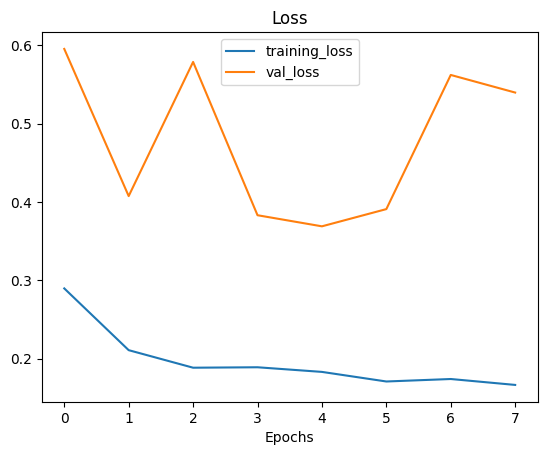

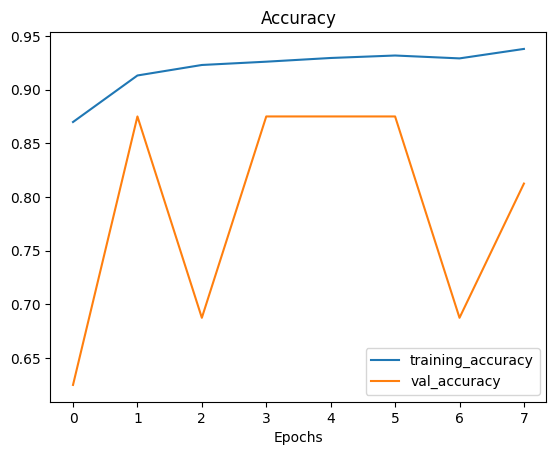

In [142]:
plot_loss_curves(resnet_history)


In [143]:
resnet_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1000)             44541480  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1001      
                                                                 
Total params: 44,542,481
Trainable params: 1,001
Non-trainable params: 44,541,480
_________________________________________________________________


In [226]:
preds_res=resnet_model.predict(test_data_rgb, verbose=1)

20/20 [==============================] - 9s 288ms/step


In [227]:
threshold = 0.5
predicted_labels_res = (preds_res >= threshold).astype(int)


In [228]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, predicted_labels_res)
accuracy

0.8525641025641025

Confusion Matrix:
[[156  78]
 [ 14 376]]


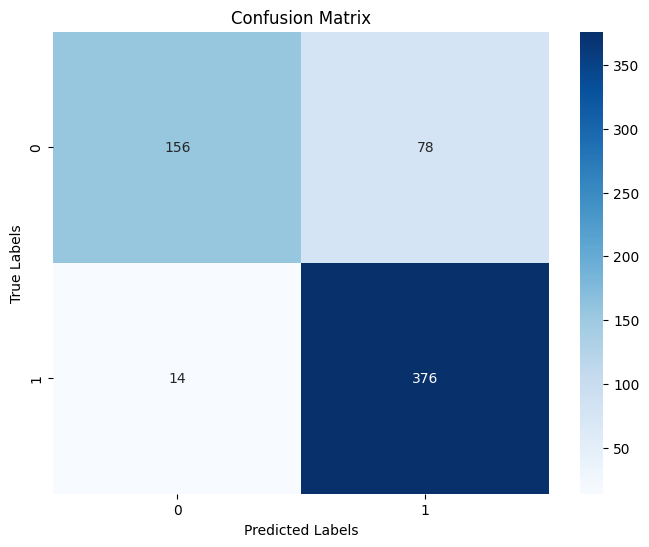

In [229]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_labels, predicted_labels_res)
print("Confusion Matrix:")
print(cm)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [230]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_labels, predicted_labels_res)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.67      0.77       234
         1.0       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



In [281]:
resnet_results = calculate_results(y_labels, predicted_labels_res)
resnet_results

{'accuracy': 85.25641025641025,
 'precision': 0.8617387924332729,
 'recall': 0.8525641025641025,
 'f1': 0.8464759983107316}

In [293]:
import pandas as pd
all_model_results = pd.DataFrame({"Model_1": model1results,
                                  "model_2": model2_results,
                                  "EfficientnetV2": efficientnet_results,
                                  "Resnet": resnet_results,

                                  })
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Model_1,0.716346,0.783497,0.716346,0.661440
model_2,0.878205,0.880426,0.878205,0.878861
EfficientnetV2,0.905449,0.908803,0.905449,0.903531
Resnet,0.852564,0.861739,0.852564,0.846476


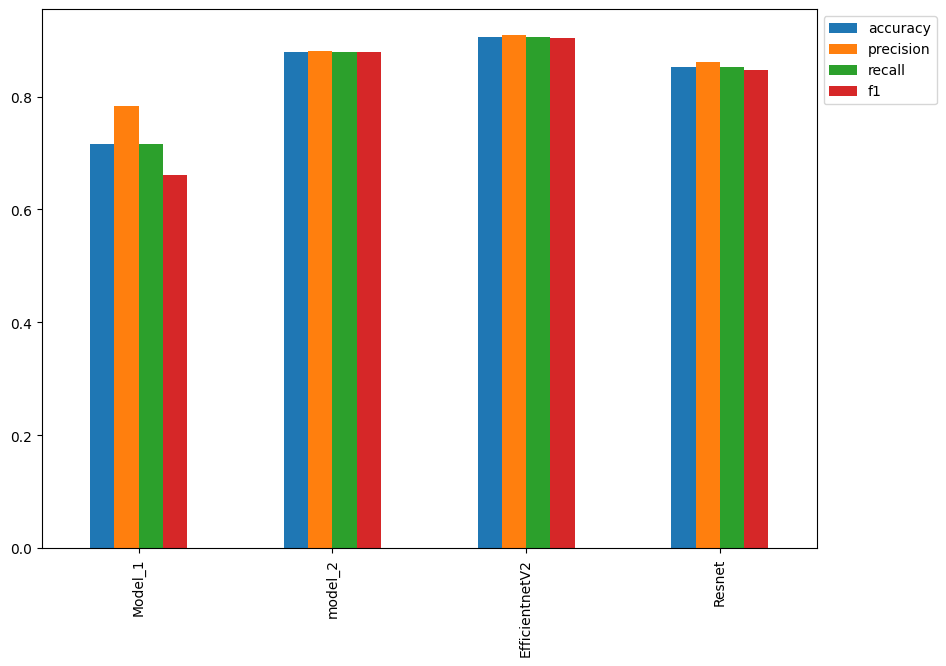

In [294]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


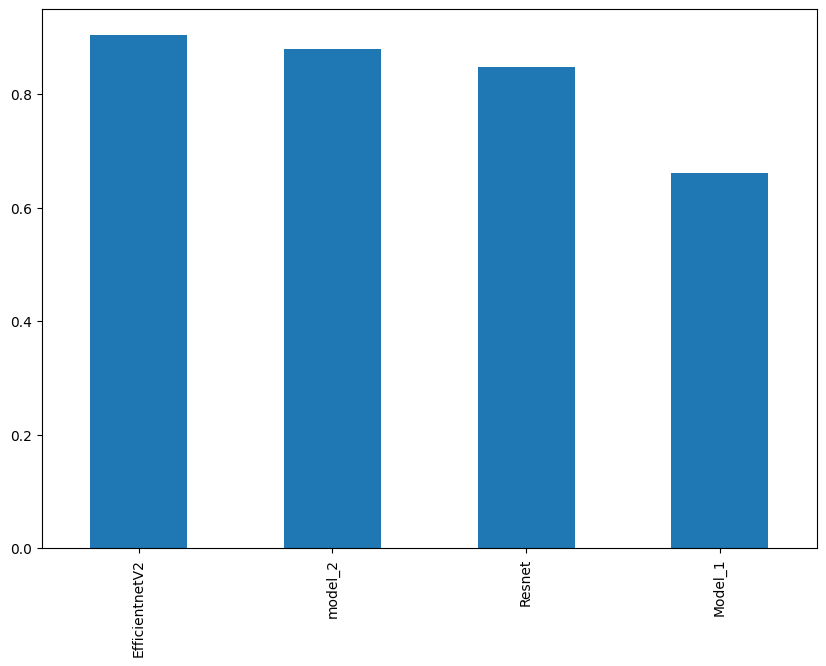

In [295]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));
